# Notebook Setup

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from matplotlib.patches import Ellipse
import streamlit as st
import pandas as pd
import plotly.express as px
from scipy.stats import zscore
from mplsoccer import VerticalPitch

pd.set_option('display.max_columns', None)

# Data Wrangling

In [2]:
from understatapi import UnderstatClient

with UnderstatClient() as understat:
    league_player_data = understat.league(league="EPL").get_player_data(season="2025")
    player_shot_data = understat.player(player="1250").get_shot_data()
    team_match_data = understat.team(team="Arsenal").get_match_data(season="2025")
    roster_data = understat.match(match="14711").get_roster_data()

In [3]:
import pandas as pd

# Assuming team_match_data is already defined
team_match_data_df = pd.json_normalize(
    team_match_data,
    sep='_'
)

# Optional: convert types where appropriate
team_match_data_df['datetime'] = pd.to_datetime(team_match_data_df['datetime'])
team_match_data_df['goals_h'] = pd.to_numeric(team_match_data_df['goals_h'], errors='coerce')
team_match_data_df['goals_a'] = pd.to_numeric(team_match_data_df['goals_a'], errors='coerce')
team_match_data_df['xG_h'] = pd.to_numeric(team_match_data_df['xG_h'], errors='coerce')
team_match_data_df['xG_a'] = pd.to_numeric(team_match_data_df['xG_a'], errors='coerce')

team_match_data_df.head()


,id,isResult,side,datetime,result,h_id,h_title,h_short_title,a_id,a_title,a_short_title,goals_h,goals_a,xG_h,xG_a,forecast_w,forecast_d,forecast_l
0,26604,True,h,2024-08-17 14:00:00,w,83,Arsenal,ARS,229,Wolverhampton Wanderers,WOL,2,0,1.628300,0.575835,0.631065,0.240743,0.128192
1,26618,True,a,2024-08-24 16:30:00,w,71,Aston Villa,AVL,83,Arsenal,ARS,0,2,1.316640,1.413990,0.349613,0.256147,0.394240
2,26622,True,h,2024-08-31 11:30:00,d,83,Arsenal,ARS,220,Brighton,BRI,1,1,2.417980,1.817480,0.514887,0.193318,0.291795
3,26640,True,a,2024-09-15 13:00:00,w,82,Tottenham,TOT,83,Arsenal,ARS,0,1,0.792595,1.120900,0.257516,0.310820,0.431665
4,26651,True,a,2024-09-22 15:30:00,d,88,Manchester City,MCI,83,Arsenal,ARS,2,2,2.755880,1.284110,0.682943,0.162175,0.154882


In [4]:
team_names = team_match_data_df['h_title'].unique()
print(team_names)

['Arsenal' 'Aston Villa' 'Tottenham' 'Manchester City' 'Bournemouth'
 'Newcastle United' 'Chelsea' 'West Ham' 'Fulham' 'Crystal Palace'
 'Brentford' 'Brighton' 'Wolverhampton Wanderers' 'Leicester'
 'Nottingham Forest' 'Manchester United' 'Everton' 'Ipswich' 'Liverpool'
 'Southampton']


In [5]:
import pandas as pd
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

all_match_data = []

for i, team in enumerate(team_names, 1):
    try:
        logging.info(f"[{i}/{len(team_names)}] Fetching match data for team: {team}")
        match_data = understat.team(team=team).get_match_data(season="2025")
        df = pd.json_normalize(match_data, sep='_')
        df['team'] = team  # tag origin team
        all_match_data.append(df)
    except Exception as e:
        logging.error(f"Error fetching match data for {team}: {e}")

# Combine into one DataFrame
team_match_data_df = pd.concat(all_match_data, ignore_index=True)

# Drop duplicates by match ID
team_match_data_df = team_match_data_df.drop_duplicates(subset='id', keep='first')

# Optional: convert datetime column
team_match_data_df['datetime'] = pd.to_datetime(team_match_data_df['datetime'])

# Final output
print(f"Final match data shape: {team_match_data_df.shape}")
team_match_data_df.head()


2025-05-30 15:44:29,229 - INFO - [1/20] Fetching match data for team: Arsenal
2025-05-30 15:44:29,739 - INFO - [2/20] Fetching match data for team: Aston Villa
2025-05-30 15:44:29,855 - INFO - [3/20] Fetching match data for team: Tottenham
2025-05-30 15:44:29,972 - INFO - [4/20] Fetching match data for team: Manchester City
2025-05-30 15:44:30,741 - INFO - [5/20] Fetching match data for team: Bournemouth
2025-05-30 15:44:30,860 - INFO - [6/20] Fetching match data for team: Newcastle United
2025-05-30 15:44:31,355 - INFO - [7/20] Fetching match data for team: Chelsea
2025-05-30 15:44:31,466 - INFO - [8/20] Fetching match data for team: West Ham
2025-05-30 15:44:31,582 - INFO - [9/20] Fetching match data for team: Fulham
2025-05-30 15:44:31,709 - INFO - [10/20] Fetching match data for team: Crystal Palace
2025-05-30 15:44:31,821 - INFO - [11/20] Fetching match data for team: Brentford
2025-05-30 15:44:31,934 - INFO - [12/20] Fetching match data for team: Brighton
2025-05-30 15:44:32,047 

Final match data shape: (380, 19)


,id,isResult,side,datetime,result,h_id,h_title,h_short_title,a_id,a_title,a_short_title,goals_h,goals_a,xG_h,xG_a,forecast_w,forecast_d,forecast_l,team
0,26604,True,h,2024-08-17 14:00:00,w,83,Arsenal,ARS,229,Wolverhampton Wanderers,WOL,2,0,1.6283,0.575835,0.631065,0.240743,0.128192,Arsenal
1,26618,True,a,2024-08-24 16:30:00,w,71,Aston Villa,AVL,83,Arsenal,ARS,0,2,1.31664,1.41399,0.349613,0.256147,0.394240,Arsenal
2,26622,True,h,2024-08-31 11:30:00,d,83,Arsenal,ARS,220,Brighton,BRI,1,1,2.41798,1.81748,0.514887,0.193318,0.291795,Arsenal
3,26640,True,a,2024-09-15 13:00:00,w,82,Tottenham,TOT,83,Arsenal,ARS,0,1,0.792595,1.1209,0.257516,0.310820,0.431665,Arsenal
4,26651,True,a,2024-09-22 15:30:00,d,88,Manchester City,MCI,83,Arsenal,ARS,2,2,2.75588,1.28411,0.682943,0.162175,0.154882,Arsenal


In [6]:

# Create DataFrame
league_player_data_pd = pd.DataFrame(league_player_data)

# Convert numeric columns that are currently strings to appropriate numeric types
numeric_cols = ['games', 'time', 'goals', 'xG', 'assists', 'xA', 'shots', 'key_passes',
                'yellow_cards', 'red_cards', 'npg', 'npxG', 'xGChain', 'xGBuildup']

for col in numeric_cols:
    if col in league_player_data_pd.columns:
        league_player_data_pd[col] = pd.to_numeric(league_player_data_pd[col], errors='coerce')

league_player_data_pd

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
0,1250,Mohamed Salah,38,3392,29,27.706267,18,15.858334,130,89,1,0,F M,Liverpool,20,20.855748,48.535889,16.206758
1,5232,Alexander Isak,34,2822,23,22.356988,6,5.448704,99,42,1,0,F,Newcastle United,19,19.312313,26.209551,3.579238
2,8260,Erling Haaland,31,2749,22,23.954593,3,3.581227,109,29,2,0,F,Manchester City,19,20.909917,22.845246,3.535369
3,4456,Chris Wood,36,3024,20,15.638655,3,3.044111,68,22,1,0,F S,Nottingham Forest,17,13.355148,14.720165,1.669209
4,6552,Bryan Mbeumo,38,3419,20,13.632161,7,10.376489,86,70,3,0,D F M,Brentford,15,9.065148,24.377113,9.351835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,13586,Olabade Aluko,1,1,0,0.000000,0,0.000000,0,0,0,0,S,Leicester,0,0.000000,0.000000,0.000000
558,13588,Gustavo Nunes,3,8,0,0.000000,0,0.000000,0,0,0,0,S,Brentford,0,0.000000,0.000000,0.000000
559,13606,Michael Golding,1,1,0,0.000000,0,0.000000,0,0,0,0,S,Leicester,0,0.000000,0.000000,0.000000
560,13636,Joachim Kayi-Sanda,2,9,0,0.000000,0,0.000000,0,0,0,0,S,Southampton,0,0.000000,0.136087,0.136087


In [7]:
import pandas as pd

all_shots = []

for player_id in league_player_data_pd['id']:
    try:
        shots = understat.player(player=str(player_id)).get_shot_data()
        df_shots = pd.DataFrame(shots)
        df_shots['player_id'] = player_id  # keep track of player ID
        all_shots.append(df_shots)
    except Exception as e:
        print(f"Error fetching shots for player {player_id}: {e}")

# Combine all shots into a single DataFrame
all_shots_df = pd.concat(all_shots, ignore_index=True)

all_shots_df


,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,15217,92,MissedShots,0.8230000305175781,0.36900001525878906,0.0623646005988121,Mohamed Salah,h,1250,OpenPlay,2014,LeftFoot,4720,Chelsea,Swansea,4,2,2014-09-13 15:00:00,Eden Hazard,Pass
1,20034,84,SavedShot,0.92,0.5320000076293945,0.4399380087852478,Mohamed Salah,a,1250,OpenPlay,2014,LeftFoot,4560,Tottenham,Chelsea,5,3,2015-01-01 17:30:00,Eden Hazard,Pass
2,46908,87,BlockedShot,0.8859999847412109,0.5659999847412109,0.09675999730825424,Mohamed Salah,h,1250,OpenPlay,2014,LeftFoot,4929,Fiorentina,Atalanta,3,2,2015-02-08 11:30:00,Mario Gomez,BallTouch
3,47192,0,SavedShot,0.9640000152587891,0.6880000305175781,0.049131400883197784,Mohamed Salah,a,1250,OpenPlay,2014,LeftFoot,4937,Sassuolo,Fiorentina,1,3,2015-02-14 17:00:00,David Pizarro,Chipped
4,47197,16,MissedShots,0.9,0.6769999694824219,0.06032019853591919,Mohamed Salah,a,1250,OpenPlay,2014,LeftFoot,4937,Sassuolo,Fiorentina,1,3,2015-02-14 17:00:00,Khouma Babacar,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62358,619436,89,SavedShot,0.9369999694824219,0.5829999923706055,0.025054186582565308,Shumaira Mheuka,h,13476,FromCorner,2024,Head,26869,Chelsea,Southampton,4,0,2025-02-25 20:15:00,Cole Palmer,Aerial
62359,633481,95,MissedShots,0.7959999847412109,0.2570000076293945,0.021105527877807617,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,Wilfred Ndidi,Pass
62360,633483,96,SavedShot,0.8280000305175781,0.46900001525878904,0.11372292041778564,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,None,Dispossessed
62361,635093,82,BlockedShot,0.8690000152587891,0.6659999847412109,0.07232024520635605,Jeremy Monga,h,13579,OpenPlay,2024,LeftFoot,26969,Leicester,Ipswich,2,0,2025-05-18 14:00:00,Bilal El Khannouss,Pass


In [8]:
filtered_shots_df = all_shots_df[all_shots_df['match_id'].isin(team_match_data_df['id'])]
filtered_shots_df

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
1099,584693,46,BlockedShot,0.874000015258789,0.33799999237060546,0.0402679517865181,Mohamed Salah,a,1250,FromCorner,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,Luis Díaz,Pass
1100,584700,64,Goal,0.9369999694824219,0.4490000152587891,0.5713244676589966,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,None,None
1101,584702,70,SavedShot,0.8369999694824218,0.5629999923706055,0.40319985151290894,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,Dominik Szoboszlai,Throughball
1102,584707,93,SavedShot,0.9309999847412109,0.34700000762939454,0.08194273710250854,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,None,None
1103,586849,20,MissedShots,0.8819999694824219,0.3139999961853027,0.06441381573677063,Mohamed Salah,h,1250,OpenPlay,2024,LeftFoot,26621,Liverpool,Brentford,2,0,2024-08-25 15:30:00,Trent Alexander-Arnold,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62358,619436,89,SavedShot,0.9369999694824219,0.5829999923706055,0.025054186582565308,Shumaira Mheuka,h,13476,FromCorner,2024,Head,26869,Chelsea,Southampton,4,0,2025-02-25 20:15:00,Cole Palmer,Aerial
62359,633481,95,MissedShots,0.7959999847412109,0.2570000076293945,0.021105527877807617,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,Wilfred Ndidi,Pass
62360,633483,96,SavedShot,0.8280000305175781,0.46900001525878904,0.11372292041778564,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,None,Dispossessed
62361,635093,82,BlockedShot,0.8690000152587891,0.6659999847412109,0.07232024520635605,Jeremy Monga,h,13579,OpenPlay,2024,LeftFoot,26969,Leicester,Ipswich,2,0,2025-05-18 14:00:00,Bilal El Khannouss,Pass


In [15]:
shots_normalised_df = filtered_shots_df.copy()


# Ensure numeric types
shots_normalised_df['X'] = pd.to_numeric(shots_normalised_df['X'], errors='coerce')
shots_normalised_df['Y'] = pd.to_numeric(shots_normalised_df['Y'], errors='coerce')

# Drop rows with invalid coordinates or team info
shots_normalised_df.dropna(subset=['X', 'Y', 'h_a'], inplace=True)

# Flip only away team shots (so they now go from right to left)
shots_normalised_df['X_final'] = shots_normalised_df.apply(
    lambda row: 1 - row['X'] if row['h_a'].lower() == 'a' else row['X'],
    axis=1
)

shots_normalised_df['Y_final'] = shots_normalised_df.apply(
    lambda row: 1 - row['Y'] if row['h_a'].lower() == 'a' else row['Y'],
    axis=1
)


shots_normalised_df

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,X_final,Y_final
1099,584693,46,BlockedShot,0.874,0.338,0.0402679517865181,Mohamed Salah,a,1250,FromCorner,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,Luis Díaz,Pass,0.126,0.662
1100,584700,64,Goal,0.937,0.449,0.5713244676589966,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,None,None,0.063,0.551
1101,584702,70,SavedShot,0.837,0.563,0.40319985151290894,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,Dominik Szoboszlai,Throughball,0.163,0.437
1102,584707,93,SavedShot,0.931,0.347,0.08194273710250854,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,None,None,0.069,0.653
1103,586849,20,MissedShots,0.882,0.314,0.06441381573677063,Mohamed Salah,h,1250,OpenPlay,2024,LeftFoot,26621,Liverpool,Brentford,2,0,2024-08-25 15:30:00,Trent Alexander-Arnold,Pass,0.882,0.314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62358,619436,89,SavedShot,0.937,0.583,0.025054186582565308,Shumaira Mheuka,h,13476,FromCorner,2024,Head,26869,Chelsea,Southampton,4,0,2025-02-25 20:15:00,Cole Palmer,Aerial,0.937,0.583
62359,633481,95,MissedShots,0.796,0.257,0.021105527877807617,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,Wilfred Ndidi,Pass,0.204,0.743
62360,633483,96,SavedShot,0.828,0.469,0.11372292041778564,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,None,Dispossessed,0.172,0.531
62361,635093,82,BlockedShot,0.869,0.666,0.07232024520635605,Jeremy Monga,h,13579,OpenPlay,2024,LeftFoot,26969,Leicester,Ipswich,2,0,2025-05-18 14:00:00,Bilal El Khannouss,Pass,0.869,0.666


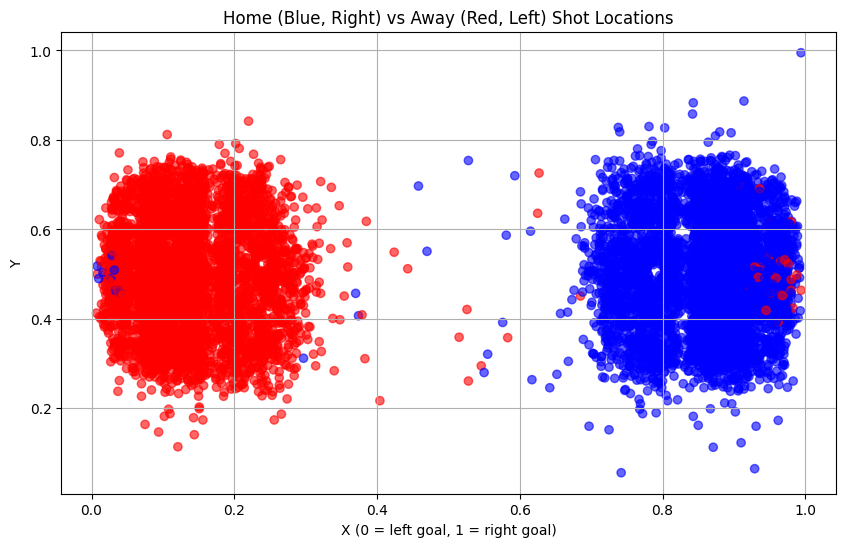

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(
    shots_normalised_df['X_final'],
    shots_normalised_df['Y_final'],
    c=shots_normalised_df['h_a'].map({'h': 'blue', 'a': 'red'}),
    alpha=0.6
)
plt.title("Home (Blue, Right) vs Away (Red, Left) Shot Locations")
plt.xlabel("X (0 = left goal, 1 = right goal)")
plt.ylabel("Y")
plt.grid(True)
plt.show()


# Load Data

In [7]:
team_match_data_df.to_pickle('team_match_data.pkl')

In [17]:
shots_normalised_df.to_pickle('shots_normalised_df.pkl')

In [145]:
shots_normalised_df= pd.read_pickle('shots_normalised_df.pkl')
team_match_data = pd.read_pickle('team_match_data.pkl')
match_statistics = pd.read_csv('match_statistics.csv')

In [5]:
shots_normalised_df

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,X_final,Y_final
1099,584693,46,BlockedShot,0.874,0.338,0.0402679517865181,Mohamed Salah,a,1250,FromCorner,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,Luis Díaz,Pass,0.126,0.662
1100,584700,64,Goal,0.937,0.449,0.5713244676589966,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,None,None,0.063,0.551
1101,584702,70,SavedShot,0.837,0.563,0.40319985151290894,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,Dominik Szoboszlai,Throughball,0.163,0.437
1102,584707,93,SavedShot,0.931,0.347,0.08194273710250854,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,None,None,0.069,0.653
1103,586849,20,MissedShots,0.882,0.314,0.06441381573677063,Mohamed Salah,h,1250,OpenPlay,2024,LeftFoot,26621,Liverpool,Brentford,2,0,2024-08-25 15:30:00,Trent Alexander-Arnold,Pass,0.882,0.314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62358,619436,89,SavedShot,0.937,0.583,0.025054186582565308,Shumaira Mheuka,h,13476,FromCorner,2024,Head,26869,Chelsea,Southampton,4,0,2025-02-25 20:15:00,Cole Palmer,Aerial,0.937,0.583
62359,633481,95,MissedShots,0.796,0.257,0.021105527877807617,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,Wilfred Ndidi,Pass,0.204,0.743
62360,633483,96,SavedShot,0.828,0.469,0.11372292041778564,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,None,Dispossessed,0.172,0.531
62361,635093,82,BlockedShot,0.869,0.666,0.07232024520635605,Jeremy Monga,h,13579,OpenPlay,2024,LeftFoot,26969,Leicester,Ipswich,2,0,2025-05-18 14:00:00,Bilal El Khannouss,Pass,0.869,0.666


In [6]:
team_match_data

,id,isResult,side,datetime,result,h_id,h_title,h_short_title,a_id,a_title,a_short_title,goals_h,goals_a,xG_h,xG_a,forecast_w,forecast_d,forecast_l,team
0,26604,True,h,2024-08-17 14:00:00,w,83,Arsenal,ARS,229,Wolverhampton Wanderers,WOL,2,0,1.6283,0.575835,0.631065,0.240743,0.128192,Arsenal
1,26618,True,a,2024-08-24 16:30:00,w,71,Aston Villa,AVL,83,Arsenal,ARS,0,2,1.31664,1.41399,0.349613,0.256147,0.394240,Arsenal
2,26622,True,h,2024-08-31 11:30:00,d,83,Arsenal,ARS,220,Brighton,BRI,1,1,2.41798,1.81748,0.514887,0.193318,0.291795,Arsenal
3,26640,True,a,2024-09-15 13:00:00,w,82,Tottenham,TOT,83,Arsenal,ARS,0,1,0.792595,1.1209,0.257516,0.310820,0.431665,Arsenal
4,26651,True,a,2024-09-22 15:30:00,d,88,Manchester City,MCI,83,Arsenal,ARS,2,2,2.75588,1.28411,0.682943,0.162175,0.154882,Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,26643,True,a,2024-09-21 14:00:00,d,74,Southampton,SOU,285,Ipswich,IPS,1,1,2.89813,1.645,0.634958,0.165477,0.199564,Ipswich
668,26827,True,a,2025-01-25 15:00:00,l,87,Liverpool,LIV,285,Ipswich,IPS,4,1,2.16809,0.804707,0.686247,0.187779,0.125973,Ipswich
669,26837,True,h,2025-02-01 15:00:00,l,285,Ipswich,IPS,74,Southampton,SOU,1,2,1.94845,1.17566,0.553458,0.219393,0.227148,Ipswich
695,26721,True,a,2024-11-24 14:00:00,w,74,Southampton,SOU,87,Liverpool,LIV,2,3,1.53985,3.18835,0.154503,0.145541,0.699955,Liverpool


In [266]:
match_statistics.to_pickle('match_statistics.pkl')

In [78]:
match_statistics

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,BFH,BFD,BFA,PSH,PSD,PSA,WHH,WHD,WHA,1XBH,1XBD,1XBA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,BFEH,BFED,BFEA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,BFE>2.5,BFE<2.5,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,BFEAHH,BFEAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,BFCH,BFCD,BFCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,1XBCH,1XBCD,1XBCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,BFECH,BFECD,BFECA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,BFEC>2.5,BFEC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA
0,E0,16/08/2024,20:00,Man United,Fulham,1,0,H,0,0,D,R Jones,14,10,5,2,12,10,7,8,2,3,0,0,1.60,4.20,5.25,1.60,4.4,5.25,1.60,4.33,5.00,1.63,4.38,5.30,1.65,4.2,5.00,1.68,4.32,5.03,1.68,4.50,5.50,1.62,4.36,5.15,1.66,4.50,5.60,1.53,2.50,1.56,2.56,1.57,2.60,1.53,2.52,1.59,2.64,-1.00,2.05,1.88,2.07,1.86,2.07,1.89,2.03,1.85,2.10,1.88,1.67,4.10,5.00,1.65,4.20,4.80,1.62,4.0,5.00,1.65,4.23,5.28,1.60,4.2,5.50,1.66,4.15,5.33,1.70,4.33,5.50,1.66,4.20,5.02,1.72,4.20,5.40,1.62,2.30,1.63,2.38,1.66,2.45,1.61,2.37,1.68,2.46,-0.75,1.86,2.07,1.83,2.11,1.88,2.11,1.82,2.05,1.90,2.08
1,E0,17/08/2024,12:30,Ipswich,Liverpool,0,2,A,0,0,D,T Robinson,7,18,2,5,9,18,2,10,3,1,0,0,8.50,5.50,1.33,7.50,5.5,1.36,8.50,5.50,1.33,8.18,5.84,1.34,8.50,5.5,1.33,8.60,5.85,1.35,9.00,6.10,1.37,8.28,5.76,1.34,9.40,6.20,1.36,1.40,3.00,1.41,3.00,1.43,3.07,1.41,2.94,1.45,3.15,1.50,2.02,1.91,1.99,1.92,2.02,1.95,1.97,1.90,2.04,1.93,8.00,5.75,1.33,8.00,5.75,1.34,7.50,5.5,1.33,8.14,6.09,1.34,8.00,5.5,1.35,8.57,5.85,1.34,8.57,6.25,1.39,7.87,5.81,1.35,8.60,6.20,1.37,1.36,3.20,1.37,3.30,1.40,3.38,1.37,3.18,1.40,3.40,1.50,2.05,1.88,2.04,1.90,2.20,2.00,1.99,1.88,2.04,1.93
2,E0,17/08/2024,15:00,Arsenal,Wolves,2,0,H,1,0,H,J Gillett,18,9,6,3,17,14,8,2,2,2,0,0,1.18,7.50,13.00,1.20,7.5,13.50,1.15,8.00,16.00,1.16,8.56,16.22,1.18,7.0,17.00,1.20,7.65,16.00,1.20,9.10,18.00,1.18,7.86,15.87,1.19,9.00,18.00,1.44,2.75,1.46,2.79,1.50,2.82,1.46,2.70,1.53,2.84,-2.00,1.93,2.00,1.88,2.00,1.97,2.00,1.90,1.96,1.94,2.00,1.14,8.50,15.00,1.16,8.50,18.00,1.13,8.5,17.00,1.15,9.05,18.76,1.15,8.0,19.00,1.16,9.39,16.60,1.17,9.40,21.00,1.15,8.62,18.11,1.17,9.40,21.00,1.40,3.00,1.41,2.98,1.45,3.00,1.42,2.93,1.44,3.20,-2.25,2.02,1.91,2.00,1.90,2.05,1.93,1.99,1.87,2.02,1.96
3,E0,17/08/2024,15:00,Everton,Brighton,0,3,A,0,1,A,S Hooper,9,10,1,5,8,8,1,5,1,1,1,0,2.63,3.30,2.63,2.65,3.4,2.60,2.70,3.40,2.63,2.73,3.36,2.71,2.60,3.5,2.70,2.68,3.66,2.63,2.76,3.66,2.78,2.67,3.41,2.68,2.78,3.50,2.78,1.80,2.00,1.83,2.05,1.85,2.08,1.81,2.04,1.88,2.08,0.00,1.96,1.97,1.96,1.94,1.97,1.97,1.94,1.94,1.99,1.99,3.10,3.40,2.30,3.00,3.40,2.37,3.00,3.3,2.30,3.15,3.41,2.40,3.10,3.3,2.40,3.16,3.47,2.34,3.16,3.50,2.45,3.06,3.40,2.38,3.15,3.55,2.46,1.93,1.97,1.93,1.97,1.95,2.00,1.89,1.96,1.94,2.04,0.25,1.87,2.06,1.86,2.07,1.92,2.10,1.83,2.04,1.88,2.11
4,E0,17/08/2024,15:00,Newcastle,Southampton,1,0,H,1,0,H,C Pawson,3,19,1,4,15,16,3,12,2,4,1,0,1.36,5.25,8.00,1.35,5.5,7.75,1.33,5.50,8.50,1.35,5.70,8.25,1.35,5.5,8.00,1.37,5.74,8.10,1.37,5.90,8.60,1.35,5.62,8.10,1.37,6.00,9.20,1.40,3.00,1.40,3.09,1.42,3.12,1.40,3.01,1.43,3.15,-1.50,1.98,1.95,1.94,1.96,1.99,1.98,1.93,1.93,1.94,2.01,1.40,5.00,7.00,1.39,5.25,7.25,1.36,5.0,7.50,1.42,5.30,7.26,1.40,5.0,7.50,1.39,5.34,7.90,1.44,5.75,8.00,1.39,5.27,7.33,1.43,5.50,8.20,1.44,2.75,1.46,2.85,1.46,3.05,1.43,2.84,1.49,2.98,-1.25,1.87,2.06,1.88,2.06,1.89,2.10,1.82,2.05,1.89,2.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
def rename_match_stats_columns(df):
    # 1. Column renaming
    rename_map = {
        # Previous mappings
        'Attendance': 'Crowd Attendance',
        'Referee': 'Match Referee',
        'HS': 'Home Team Shots',
        'AS': 'Away Team Shots',
        'HST': 'Home Team Shots on Target',
        'AST': 'Away Team Shots on Target',
        'HHW': 'Home Team Hit Woodwork',
        'AHW': 'Away Team Hit Woodwork',
        'HC': 'Home Team Corners',
        'AC': 'Away Team Corners',
        'HF': 'Home Team Fouls Committed',
        'AF': 'Away Team Fouls Committed',
        'HFKC': 'Home Team Free Kicks Conceded',
        'AFKC': 'Away Team Free Kicks Conceded',
        'HO': 'Home Team Offsides',
        'AO': 'Away Team Offsides',
        'HY': 'Home Team Yellow Cards',
        'AY': 'Away Team Yellow Cards',
        'HR': 'Home Team Red Cards',
        'AR': 'Away Team Red Cards',
        'HBP': 'Home Team Bookings Points',
        'ABP': 'Away Team Bookings Points',

        # New mappings
        'Div': 'League Division',
        'Date': 'Match Date (dd/mm/yy)',
        'Time': 'Time of Match Kick Off',
        'HomeTeam': 'h_team',
        'AwayTeam': 'a_team',
        'FTHG': 'Full Time Home Team Goals',
        'HG': 'Full Time Home Team Goals',
        'FTAG': 'Full Time Away Team Goals',
        'AG': 'Full Time Away Team Goals',
        'FTR': 'Full Time Result',
        'Res': 'Full Time Result',
        'HTHG': 'Half Time Home Team Goals',
        'HTAG': 'Half Time Away Team Goals',
        'HTR': 'Half Time Result'
    }

    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    # 2. Team name standardisation
    TEAM_NAME_MAPPING = {
        'Man United': 'Manchester United',
        'Man City': 'Manchester City',
        "Nott'm Forest": 'Nottingham Forest',
        'Wolves': 'Wolverhampton Wanderers',
    }

    def standardise_team_name(name):
        return TEAM_NAME_MAPPING.get(name.strip(), name.strip())

    if 'h_team' in df.columns:
        df['h_team'] = df['h_team'].apply(standardise_team_name)
    if 'a_team' in df.columns:
        df['a_team'] = df['a_team'].apply(standardise_team_name)

    return df

match_statistics = rename_match_stats_columns(match_statistics)


In [147]:
match_statistics

,League Division,Match Date (dd/mm/yy),Time of Match Kick Off,h_team,a_team,Full Time Home Team Goals,Full Time Away Team Goals,Full Time Result,Half Time Home Team Goals,Half Time Away Team Goals,Half Time Result,Match Referee,Home Team Shots,Away Team Shots,Home Team Shots on Target,Away Team Shots on Target,Home Team Fouls Committed,Away Team Fouls Committed,Home Team Corners,Away Team Corners,Home Team Yellow Cards,Away Team Yellow Cards,Home Team Red Cards,Away Team Red Cards,B365H,B365D,B365A,BWH,BWD,BWA,BFH,BFD,BFA,PSH,PSD,PSA,WHH,WHD,WHA,1XBH,1XBD,1XBA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,BFEH,BFED,BFEA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,BFE>2.5,BFE<2.5,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,BFEAHH,BFEAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,BFCH,BFCD,BFCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,1XBCH,1XBCD,1XBCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,BFECH,BFECD,BFECA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,BFEC>2.5,BFEC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA
0,E0,16/08/2024,20:00,Manchester United,Fulham,1,0,H,0,0,D,R Jones,14,10,5,2,12,10,7,8,2,3,0,0,1.60,4.20,5.25,1.60,4.4,5.25,1.60,4.33,5.00,1.63,4.38,5.30,1.65,4.2,5.00,1.68,4.32,5.03,1.68,4.50,5.50,1.62,4.36,5.15,1.66,4.50,5.60,1.53,2.50,1.56,2.56,1.57,2.60,1.53,2.52,1.59,2.64,-1.00,2.05,1.88,2.07,1.86,2.07,1.89,2.03,1.85,2.10,1.88,1.67,4.10,5.00,1.65,4.20,4.80,1.62,4.0,5.00,1.65,4.23,5.28,1.60,4.2,5.50,1.66,4.15,5.33,1.70,4.33,5.50,1.66,4.20,5.02,1.72,4.20,5.40,1.62,2.30,1.63,2.38,1.66,2.45,1.61,2.37,1.68,2.46,-0.75,1.86,2.07,1.83,2.11,1.88,2.11,1.82,2.05,1.90,2.08
1,E0,17/08/2024,12:30,Ipswich,Liverpool,0,2,A,0,0,D,T Robinson,7,18,2,5,9,18,2,10,3,1,0,0,8.50,5.50,1.33,7.50,5.5,1.36,8.50,5.50,1.33,8.18,5.84,1.34,8.50,5.5,1.33,8.60,5.85,1.35,9.00,6.10,1.37,8.28,5.76,1.34,9.40,6.20,1.36,1.40,3.00,1.41,3.00,1.43,3.07,1.41,2.94,1.45,3.15,1.50,2.02,1.91,1.99,1.92,2.02,1.95,1.97,1.90,2.04,1.93,8.00,5.75,1.33,8.00,5.75,1.34,7.50,5.5,1.33,8.14,6.09,1.34,8.00,5.5,1.35,8.57,5.85,1.34,8.57,6.25,1.39,7.87,5.81,1.35,8.60,6.20,1.37,1.36,3.20,1.37,3.30,1.40,3.38,1.37,3.18,1.40,3.40,1.50,2.05,1.88,2.04,1.90,2.20,2.00,1.99,1.88,2.04,1.93
2,E0,17/08/2024,15:00,Arsenal,Wolverhampton Wanderers,2,0,H,1,0,H,J Gillett,18,9,6,3,17,14,8,2,2,2,0,0,1.18,7.50,13.00,1.20,7.5,13.50,1.15,8.00,16.00,1.16,8.56,16.22,1.18,7.0,17.00,1.20,7.65,16.00,1.20,9.10,18.00,1.18,7.86,15.87,1.19,9.00,18.00,1.44,2.75,1.46,2.79,1.50,2.82,1.46,2.70,1.53,2.84,-2.00,1.93,2.00,1.88,2.00,1.97,2.00,1.90,1.96,1.94,2.00,1.14,8.50,15.00,1.16,8.50,18.00,1.13,8.5,17.00,1.15,9.05,18.76,1.15,8.0,19.00,1.16,9.39,16.60,1.17,9.40,21.00,1.15,8.62,18.11,1.17,9.40,21.00,1.40,3.00,1.41,2.98,1.45,3.00,1.42,2.93,1.44,3.20,-2.25,2.02,1.91,2.00,1.90,2.05,1.93,1.99,1.87,2.02,1.96
3,E0,17/08/2024,15:00,Everton,Brighton,0,3,A,0,1,A,S Hooper,9,10,1,5,8,8,1,5,1,1,1,0,2.63,3.30,2.63,2.65,3.4,2.60,2.70,3.40,2.63,2.73,3.36,2.71,2.60,3.5,2.70,2.68,3.66,2.63,2.76,3.66,2.78,2.67,3.41,2.68,2.78,3.50,2.78,1.80,2.00,1.83,2.05,1.85,2.08,1.81,2.04,1.88,2.08,0.00,1.96,1.97,1.96,1.94,1.97,1.97,1.94,1.94,1.99,1.99,3.10,3.40,2.30,3.00,3.40,2.37,3.00,3.3,2.30,3.15,3.41,2.40,3.10,3.3,2.40,3.16,3.47,2.34,3.16,3.50,2.45,3.06,3.40,2.38,3.15,3.55,2.46,1.93,1.97,1.93,1.97,1.95,2.00,1.89,1.96,1.94,2.04,0.25,1.87,2.06,1.86,2.07,1.92,2.10,1.83,2.04,1.88,2.11
4,E0,17/08/2024,15:00,Newcastle,Southampton,1,0,H,1,0,H,C Pawson,3,19,1,4,15,16,3,12,2,4,1,0,1.36,5.25,8.00,1.35,5.5,7.75,1.33,5.50,8.50,1.35,5.70,8.25,1.35,5.5,8.00,1.37,5.74,8.10,1.37,5.90,8.60,1.35,5.62,8.10,1.37,6.00,9.20,1.40,3.00,1.40,3.09,1.42,3.12,1.40,3.01,1.43,3.15,-1.50,1.98,1.95,1.94,1.96,1.99,1.98,1.93,1.93,1.94,2.01,1.40,5.00,7.00,1.39,5.25,7.25,1.36,5.0,7.50,1.42,5.30,7.26,1.40,5.0,7.50,1.39,5.34,7.90,1.44,5.75,8.00,1.39,5.27,7.33,1.43,5.50,8.20,1.44,2.75,1.46,2.85,1.46,3.05,1.43,2.84,1.49,2.98,-1.25,1.87,2.06,1.88,2.06,1.89,2.10,1.82,2.05,1.89,2.10
...,...,...,...,...,...,...,...,...,...,...,

In [31]:
print("Min X:", all_shots_df['X'].min())
print("Max X:", all_shots_df['X'].max())


Min X: 0.004000000059604645
Max X: 0.999000015258789


In [18]:
print("Min Y:", all_shots_df['Y'].min())
print("Max Y:", all_shots_df['Y'].max())

Min Y: 0.00800000011920929
Max Y: 0.995


# Functions

In [214]:
def plot_match_shots(shots_normalised_df, match_statistics, h_team, a_team):
    """
    Plots both teams' shots on a full horizontal pitch:
    - Home team attacking left (left to right), away team attacking right (right to left) swapped
    - All shots black except goals: home goals red, away goals blue (swapped colors)
    - Facecolors have 50% opacity, edges fully opaque black
    - Displays key match statistics at center pitch with stat names in the middle,
      home stats on left in red, away stats on right in blue.
      Additionally, prints team names above home and away stats with white outline.
    - Adds a key at the bottom showing that xG means the size of the circle.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from mplsoccer import Pitch
    import matplotlib.colors as mcolors
    import matplotlib.patheffects as path_effects

    # Clean team names in shots df
    shots_normalised_df['h_team'] = shots_normalised_df['h_team'].str.strip()
    shots_normalised_df['a_team'] = shots_normalised_df['a_team'].str.strip()

    # Filter shots for the match
    match_shots = shots_normalised_df[
        (shots_normalised_df['h_team'] == h_team) & (shots_normalised_df['a_team'] == a_team)
    ].copy()

    if match_shots.empty:
        print(f"No shots found for match: {h_team} vs {a_team}")
        return

    # Convert to numeric & scale coordinates
    match_shots['X_final'] = pd.to_numeric(match_shots['X_final'], errors='coerce') * 120
    match_shots['Y_final'] = pd.to_numeric(match_shots['Y_final'], errors='coerce') * 80
    match_shots['xG'] = pd.to_numeric(match_shots['xG'], errors='coerce').fillna(0)
    match_shots.dropna(subset=['X_final', 'Y_final'], inplace=True)

    # Split into home and away shots
    home_shots = match_shots[match_shots['h_a'] == 'h'].copy()
    away_shots = match_shots[match_shots['h_a'] == 'a'].copy()

    # Sizes for shot markers
    min_size = 50
    home_sizes = np.clip(home_shots['xG'] * 1000, min_size, None)
    away_sizes = np.clip(away_shots['xG'] * 1000, min_size, None)

    # Define shot colors: home goals red, away goals blue; all else black
    def shot_color(row):
        if str(row['result']).lower() == 'goal':
            return 'red' if row['h_a'] == 'h' else 'blue'
        return 'black'

    home_colors = home_shots.apply(shot_color, axis=1)
    away_colors = away_shots.apply(shot_color, axis=1)

    # Function to add alpha to color
    def apply_alpha(color, alpha=0.3):
        rgba = list(mcolors.to_rgba(color))
        rgba[3] = alpha
        return tuple(rgba)

    home_colors_alpha = home_colors.apply(lambda c: apply_alpha(c, 0.5))
    away_colors_alpha = away_colors.apply(lambda c: apply_alpha(c, 0.5))

    # Flip X for correct direction
    home_shots['X_final'] = 120 - home_shots['X_final']
    away_shots['X_final'] = 120 - away_shots['X_final']

    pitch = Pitch(pitch_type='statsbomb', pitch_color='#262730', line_color='white')
    fig, ax = pitch.draw(figsize=(12, 8))

    # Plot home and away shots
    pitch.scatter(
        home_shots['X_final'], home_shots['Y_final'],
        s=home_sizes, ax=ax,
        facecolors=home_colors_alpha, edgecolors='black', linewidth=2,
        label=f"{h_team} shots"
    )
    pitch.scatter(
        away_shots['X_final'], away_shots['Y_final'],
        s=away_sizes, ax=ax,
        facecolors=away_colors_alpha, edgecolors='black', linewidth=2,
        label=f"{a_team} shots"
    )

    # Add team names at the top with white outline
    y_team = 10  # slightly above the pitch
    x_home_team = 120 * 0.20
    x_away_team = 120 * 0.80

    home_text = ax.text(
        x_home_team, y_team, h_team,
        ha='center', va='bottom', fontsize=26, color='red', fontweight='bold'
    )
    away_text = ax.text(
        x_away_team, y_team, a_team,
        ha='center', va='bottom', fontsize=26, color='blue', fontweight='bold'
    )

    for txt in [home_text, away_text]:
        txt.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground='white'),
            path_effects.Normal()
        ])

    # Calculate xG sums from shots dataframe
    home_xg = home_shots['xG'].sum()
    away_xg = away_shots['xG'].sum()

    # Get goals from match_statistics
    match_stats_row = match_statistics[
        (match_statistics['h_team'] == h_team) & (match_statistics['a_team'] == a_team)
    ]

    if match_stats_row.empty:
        print(f"No match statistics found for {h_team} vs {a_team}")
        return

    home_goals = match_stats_row['Full Time Home Team Goals'].values[0]
    away_goals = match_stats_row['Full Time Away Team Goals'].values[0]

    # Define order and map for stats to display
    stats_order = [
        'Goals',
        'xG',
        'Shots',
        'Shots on Target',
        'Corners',
        'Fouls Committed',
        'Yellow Cards',
        'Red Cards'
    ]

    stat_map = {
        'Shots': 'Shots',
        'Shots on Target': 'Shots on Target',
        'Corners': 'Corners',
        'Fouls Committed': 'Fouls Committed',
        'Yellow Cards': 'Yellow Cards',
        'Red Cards': 'Red Cards'
    }

    # Y positions top to bottom
    y_positions = np.linspace(20, 60, len(stats_order))  # swapped 60,20 -> 20,60

    x_home, x_stat, x_away = 120 * 0.35, 60, 120 * 0.65

    for i, stat_name in enumerate(stats_order):
        if stat_name == 'Goals':
            home_val = home_goals
            away_val = away_goals
        elif stat_name == 'xG':
            home_val = round(home_xg, 2)
            away_val = round(away_xg, 2)
        else:
            home_col = 'Home Team ' + stat_map[stat_name]
            away_col = 'Away Team ' + stat_map[stat_name]
            home_val = match_stats_row[home_col].values[0]
            away_val = match_stats_row[away_col].values[0]

        ax.text(x_home, y_positions[i], str(home_val), ha='center', va='center',
                fontsize=20, color='red', fontweight='bold',
                path_effects=[path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
        ax.text(x_away, y_positions[i], str(away_val), ha='center', va='center',
                fontsize=20, color='blue', fontweight='bold',
                path_effects=[path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
        stat_text = ax.text(x_stat, y_positions[i], stat_name, ha='center', va='center',
                            fontsize=20, color='black', fontweight='bold',
                            path_effects=[path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
    
    legend_y = 75  # vertical position on pitch
    start_x = 40   # start x coordinate for the legend group

    # Plot black circle for shot
    ax.scatter(start_x, legend_y, s=100, c='black', edgecolors='black', linewidth=1)

    # Text next to black circle
    ax.text(start_x + 3, legend_y, '= Shot', ha='left', va='center',
            fontsize=14, color='white', fontweight='bold')

    # Plot red circle for goal
    ax.scatter(start_x + 25, legend_y, s=100, c='red', edgecolors='black', linewidth=1)

    # Text next to red circle
    ax.text(start_x + 28, legend_y, '= Goal', ha='left', va='center',
            fontsize=14, color='white', fontweight='bold')


    plt.show()


In [229]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_home_goal_density(match_statistics, h_team, a_team):
    # Filter all matches where the selected team played at home
    team_home_matches = match_statistics[match_statistics['h_team'] == h_team]

    # Get the number of goals they scored in this specific match
    match_row = match_statistics[
        (match_statistics['h_team'] == h_team) &
        (match_statistics['a_team'] == a_team)
    ]

    if match_row.empty:
        print(f"No match found for {h_team} vs {a_team}")
        return

    goals_this_match = match_row['Full Time Home Team Goals'].values[0]
    all_goals = team_home_matches['Full Time Home Team Goals']

    # Create the styled density plot
    fig, ax = plt.subplots(figsize=(10, 5))

    # Background colors
    fig.patch.set_facecolor('#262730')
    ax.set_facecolor('#262730')

    # Plot KDE (clipped to avoid negative x-axis)
    sns.kdeplot(
        all_goals, fill=True, color='#b0b0b0', alpha=0.5, linewidth=2, ax=ax,
        clip=(0, all_goals.max() + 1)  # avoid negatives
    )

    # Average line
    avg_goals = all_goals.mean()
    avg_line = ax.axvline(avg_goals, color='gray', linestyle='--', linewidth=1.5, label='Average')

    # Match-specific line
    match_line = ax.axvline(goals_this_match, color='red', linestyle='-', linewidth=2,
                            label=f'{h_team} vs {a_team}: {goals_this_match} goals')

    # Labels and title
    ax.set_title(f"{h_team}'s Home Goal Distribution", fontsize=14, color='white')
    ax.set_xlabel("Goals Scored", color='white')
    ax.set_ylabel("Density", color='white')

    # Legend styling
    legend = ax.legend(loc='upper right', fontsize=10, facecolor='#262730', edgecolor='white', labelcolor='white')
    for text in legend.get_texts():
        text.set_color('white')

    # Ticks and spines
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    for spine in ax.spines.values():
        spine.set_color('white')

    plt.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()
    plt.show()


In [232]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_away_goal_density(match_statistics, h_team, a_team):
    # Filter all matches where the selected team played away
    team_away_matches = match_statistics[match_statistics['a_team'] == a_team]

    # Get the number of goals they scored in this specific match
    match_row = match_statistics[
        (match_statistics['h_team'] == h_team) &
        (match_statistics['a_team'] == a_team)
    ]

    if match_row.empty:
        print(f"No match found for {h_team} vs {a_team}")
        return

    goals_this_match = match_row['Full Time Away Team Goals'].values[0]
    all_goals = team_away_matches['Full Time Away Team Goals']

    # Create the styled density plot
    fig, ax = plt.subplots(figsize=(10, 5))

    # Background colors
    fig.patch.set_facecolor('#262730')
    ax.set_facecolor('#262730')

    # Plot KDE (clipped to avoid negative x-axis)
    sns.kdeplot(
        all_goals, fill=True, color='#b0b0b0', alpha=0.5, linewidth=2, ax=ax,
        clip=(0, all_goals.max() + 1)  # avoid negatives
    )

    # Average line
    avg_goals = all_goals.mean()
    avg_line = ax.axvline(avg_goals, color='gray', linestyle='--', linewidth=1.5, label='Average')

    # Match-specific line
    match_line = ax.axvline(goals_this_match, color='blue', linestyle='-', linewidth=2,
                            label=f'{a_team} @ {h_team}: {goals_this_match} goals')

    # Labels and title
    ax.set_title(f"{a_team}'s Away Goal Distribution", fontsize=14, color='white')
    ax.set_xlabel("Goals Scored", color='white')
    ax.set_ylabel("Density", color='white')

    # Legend styling
    legend = ax.legend(loc='upper right', fontsize=10, facecolor='#262730', edgecolor='white', labelcolor='white')
    for text in legend.get_texts():
        text.set_color('white')

    # Ticks and spines
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    for spine in ax.spines.values():
        spine.set_color('white')

    plt.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()
    plt.show()


In [242]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_away_xG_density(shots_normalised_df, match_statistics, h_team, a_team):
    """
    Plots the KDE density of xG for the away team playing away,
    plus a vertical line for the specific match's xG value.
    """
    # Clean team names to be safe
    shots_normalised_df['h_team'] = shots_normalised_df['h_team'].str.strip().str.title()
    shots_normalised_df['a_team'] = shots_normalised_df['a_team'].str.strip().str.title()
    
    # Filter shots where team played away
    team_away_shots = shots_normalised_df[
        (shots_normalised_df['a_team'] == a_team) & (shots_normalised_df['h_a'] == 'a')
    ].copy()
    
    # Ensure xG is numeric
    team_away_shots['xG'] = pd.to_numeric(team_away_shots['xG'], errors='coerce')
    team_away_shots = team_away_shots.dropna(subset=['xG'])
    
    # Aggregate total xG per away match (group by h_team and a_team)
    agg_xg = team_away_shots.groupby(['h_team', 'a_team'])['xG'].sum().reset_index()
    
    # Get all aggregated xG values for this away team
    all_xg = agg_xg[agg_xg['a_team'] == a_team]['xG']
    
    if all_xg.empty:
        print(f"No xG data available for away team {a_team}")
        return
    
    # Find xG for the specific match h_team vs a_team
    match_xg_row = agg_xg[(agg_xg['h_team'] == h_team) & (agg_xg['a_team'] == a_team)]
    if match_xg_row.empty:
        print(f"No xG found for match {h_team} vs {a_team}")
        return
    xg_this_match = match_xg_row['xG'].values[0]
    
    # Plot KDE density
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('#262730')
    ax.set_facecolor('#262730')
    
    sns.kdeplot(
        all_xg, fill=True, color='#b0b0b0', alpha=0.5, linewidth=2, ax=ax,
        clip=(0, all_xg.max() + 1)
    )
    
    # Average line
    avg_xg = all_xg.mean()
    ax.axvline(avg_xg, color='gray', linestyle='--', linewidth=1.5, label='Average xG')
    
    # Match-specific line
    ax.axvline(xg_this_match, color='blue', linestyle='-', linewidth=2,
               label=f'{a_team} @ {h_team}: {xg_this_match:.2f} xG')
    
    # Labels and title
    ax.set_title(f"{a_team}'s Away xG Distribution", fontsize=14, color='white')
    ax.set_xlabel("Expected Goals (xG)", color='white')
    ax.set_ylabel("Density", color='white')
    
    # Legend styling
    legend = ax.legend(loc='upper right', fontsize=10, facecolor='#262730', edgecolor='white', labelcolor='white')
    for text in legend.get_texts():
        text.set_color('white')
    
    # Ticks and spines
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    for spine in ax.spines.values():
        spine.set_color('white')
    
    plt.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()
    plt.show()


In [245]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_home_xG_density(shots_normalised_df, match_statistics, h_team, a_team):
    """
    Plots the KDE density of xG for the home team playing at home,
    plus a vertical line for the specific match's xG value.
    """
    # Clean team names for consistency
    shots_normalised_df['h_team'] = shots_normalised_df['h_team'].str.strip().str.title()
    shots_normalised_df['a_team'] = shots_normalised_df['a_team'].str.strip().str.title()
    
    # Filter shots where team played at home
    team_home_shots = shots_normalised_df[
        (shots_normalised_df['h_team'] == h_team) & (shots_normalised_df['h_a'] == 'h')
    ].copy()
    
    # Ensure xG is numeric and drop missing
    team_home_shots['xG'] = pd.to_numeric(team_home_shots['xG'], errors='coerce')
    team_home_shots = team_home_shots.dropna(subset=['xG'])
    
    # Aggregate total xG per home match (group by h_team and a_team)
    agg_xg = team_home_shots.groupby(['h_team', 'a_team'])['xG'].sum().reset_index()
    
    # Get all aggregated xG values for this home team
    all_xg = agg_xg[agg_xg['h_team'] == h_team]['xG']
    
    if all_xg.empty:
        print(f"No xG data available for home team {h_team}")
        return
    
    # Find xG for the specific match h_team vs a_team
    match_xg_row = agg_xg[(agg_xg['h_team'] == h_team) & (agg_xg['a_team'] == a_team)]
    if match_xg_row.empty:
        print(f"No xG found for match {h_team} vs {a_team}")
        return
    xg_this_match = match_xg_row['xG'].values[0]
    
    # Plot KDE density
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('#262730')
    ax.set_facecolor('#262730')
    
    sns.kdeplot(
        all_xg, fill=True, color='#b0b0b0', alpha=0.5, linewidth=2, ax=ax,
        clip=(0, all_xg.max() + 1)
    )
    
    # Average line
    avg_xg = all_xg.mean()
    ax.axvline(avg_xg, color='gray', linestyle='--', linewidth=1.5, label='Average xG')
    
    # Match-specific line
    ax.axvline(xg_this_match, color='red', linestyle='-', linewidth=2,
               label=f'{h_team} vs {a_team}: {xg_this_match:.2f} xG')
    
    # Labels and title
    ax.set_title(f"{h_team}'s Home xG Distribution", fontsize=14, color='white')
    ax.set_xlabel("Expected Goals (xG)", color='white')
    ax.set_ylabel("Density", color='white')
    
    # Legend styling
    legend = ax.legend(loc='upper right', fontsize=10, facecolor='#262730', edgecolor='white', labelcolor='white')
    for text in legend.get_texts():
        text.set_color('white')
    
    # Ticks and spines
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    for spine in ax.spines.values():
        spine.set_color('white')
    
    plt.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()
    plt.show()


In [249]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_home_shots_density(shots_normalised_df, h_team, a_team):
    """
    Plots the KDE density of the total shots taken by the home team in all their home matches,
    plus a vertical line for the shots taken in the specific match.
    """
    # Clean team names for consistency
    shots_normalised_df['h_team'] = shots_normalised_df['h_team'].str.strip().str.title()
    shots_normalised_df['a_team'] = shots_normalised_df['a_team'].str.strip().str.title()
    
    # Filter shots where team played at home
    team_home_shots = shots_normalised_df[
        (shots_normalised_df['h_team'] == h_team) & (shots_normalised_df['h_a'] == 'h')
    ].copy()
    
    # Aggregate total shots per match (group by h_team and a_team)
    agg_shots = team_home_shots.groupby(['h_team', 'a_team']).size().reset_index(name='shots')
    
    # Get all shots values for this home team
    all_shots = agg_shots[agg_shots['h_team'] == h_team]['shots']
    
    if all_shots.empty:
        print(f"No shot data available for home team {h_team}")
        return
    
    # Find shots count for the specific match h_team vs a_team
    match_shots_row = agg_shots[(agg_shots['h_team'] == h_team) & (agg_shots['a_team'] == a_team)]
    if match_shots_row.empty:
        print(f"No shots found for match {h_team} vs {a_team}")
        return
    shots_this_match = match_shots_row['shots'].values[0]
    
    # Plot KDE density
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('#262730')
    ax.set_facecolor('#262730')
    
    sns.kdeplot(
        all_shots, fill=True, color='#b0b0b0', alpha=0.5, linewidth=2, ax=ax,
        clip=(0, all_shots.max() + 1)
    )
    
    # Average line
    avg_shots = all_shots.mean()
    ax.axvline(avg_shots, color='gray', linestyle='--', linewidth=1.5, label='Average Shots')
    
    # Match-specific line
    ax.axvline(shots_this_match, color='red', linestyle='-', linewidth=2,
               label=f'{h_team} vs {a_team}: {shots_this_match} shots')
    
    # Labels and title
    ax.set_title(f"{h_team}'s Home Shots Distribution", fontsize=14, color='white')
    ax.set_xlabel("Number of Shots", color='white')
    ax.set_ylabel("Density", color='white')
    
    # Legend styling
    legend = ax.legend(loc='upper right', fontsize=10, facecolor='#262730', edgecolor='white', labelcolor='white')
    for text in legend.get_texts():
        text.set_color('white')
    
    # Ticks and spines
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    for spine in ax.spines.values():
        spine.set_color('white')
    
    plt.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()
    plt.show()


In [263]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_away_shots_density(shots_normalised_df, h_team, a_team):
    """
    Plots the KDE density of the total shots taken by the away team in all their away matches,
    plus a vertical line for the shots taken in the specific match.
    """
    # Clean team names for consistency
    shots_normalised_df['h_team'] = shots_normalised_df['h_team'].str.strip().str.title()
    shots_normalised_df['a_team'] = shots_normalised_df['a_team'].str.strip().str.title()
    
    # Filter shots where team played away
    team_away_shots = shots_normalised_df[
        (shots_normalised_df['a_team'] == a_team) & (shots_normalised_df['h_a'] == 'a')
    ].copy()
    
    # Aggregate total shots per match (group by h_team and a_team)
    agg_shots = team_away_shots.groupby(['h_team', 'a_team']).size().reset_index(name='shots')
    
    # Get all shots values for this away team
    all_shots = agg_shots[agg_shots['a_team'] == a_team]['shots']
    
    if all_shots.empty:
        print(f"No shot data available for away team {a_team}")
        return
    
    # Find shots count for the specific match h_team vs a_team
    match_shots_row = agg_shots[(agg_shots['h_team'] == h_team) & (agg_shots['a_team'] == a_team)]
    if match_shots_row.empty:
        print(f"No shots found for match {h_team} vs {a_team}")
        return
    shots_this_match = match_shots_row['shots'].values[0]
    
    # Plot KDE density
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor('#262730')
    ax.set_facecolor('#262730')
    
    sns.kdeplot(
        all_shots, fill=True, color='#b0b0b0', alpha=0.5, linewidth=2, ax=ax,
        clip=(0, all_shots.max() + 1)
    )
    
    # Average line
    avg_shots = all_shots.mean()
    ax.axvline(avg_shots, color='gray', linestyle='--', linewidth=1.5, label='Average Shots')
    
    # Match-specific line
    ax.axvline(shots_this_match, color='blue', linestyle='-', linewidth=2,
               label=f'{a_team} @ {h_team}: {shots_this_match} shots')
    
    # Labels and title
    ax.set_title(f"{a_team}'s Away Shots Distribution", fontsize=14, color='white')
    ax.set_xlabel("Number of Shots", color='white')
    ax.set_ylabel("Density", color='white')
    
    # Legend styling
    legend = ax.legend(loc='upper right', fontsize=10, facecolor='#262730', edgecolor='white', labelcolor='white')
    for text in legend.get_texts():
        text.set_color('white')
    
    # Ticks and spines
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    for spine in ax.spines.values():
        spine.set_color('white')
    
    plt.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()
    plt.show()


In [271]:
def filtered_shot_dataframe(shots_normalised_df, h_team, a_team):
    """
    Filters the shots_normalised_df for rows where the home team and away team
    match the given inputs. Assumes team names may have inconsistent casing/whitespace.
    
    Parameters:
        shots_normalised_df (pd.DataFrame): The dataframe containing shot data.
        h_team (str): Home team name to filter by.
        a_team (str): Away team name to filter by.
    
    Returns:
        pd.DataFrame: Filtered dataframe with rows matching the teams.
    """
    # Clean team names in the dataframe for consistency
    df = shots_normalised_df.copy()
    df['h_team'] = df['h_team'].str.strip().str.title()
    df['a_team'] = df['a_team'].str.strip().str.title()

    # Clean input team names similarly
    h_team_clean = h_team.strip().title()
    a_team_clean = a_team.strip().title()

    # Filter rows based on teams
    filtered_df = df[(df['h_team'] == h_team_clean) & (df['a_team'] == a_team_clean)]

    return filtered_df


# Output

In [272]:
filtered_shot_dataframe(shots_normalised_df,h_team='Arsenal',a_team='Manchester City')

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,X_final,Y_final
2205,615611,54,Goal,0.949,0.532,0.4302590787410736,Erling Haaland,a,8260,OpenPlay,2024,Head,26833,Arsenal,Manchester City,5,1,2025-02-02 16:30:00,Sávio,Chipped,0.051,0.468
9745,615601,0,SavedShot,0.784,0.697,0.01978301629424095,Kai Havertz,h,5220,OpenPlay,2024,LeftFoot,26833,Arsenal,Manchester City,5,1,2025-02-02 16:30:00,Gabriel Martinelli,BallTouch,0.784,0.697
9746,615606,25,MissedShots,0.874,0.517,0.4002084732055664,Kai Havertz,h,5220,OpenPlay,2024,LeftFoot,26833,Arsenal,Manchester City,5,1,2025-02-02 16:30:00,Declan Rice,BallRecovery,0.874,0.517
9747,615613,59,BlockedShot,0.847,0.597,0.09467197209596634,Kai Havertz,h,5220,OpenPlay,2024,LeftFoot,26833,Arsenal,Manchester City,5,1,2025-02-02 16:30:00,Thomas Partey,Pass,0.847,0.597
9748,615616,75,Goal,0.915,0.386,0.1338338404893875,Kai Havertz,h,5220,OpenPlay,2024,LeftFoot,26833,Arsenal,Manchester City,5,1,2025-02-02 16:30:00,Gabriel Martinelli,Pass,0.915,0.386
12726,615615,67,SavedShot,0.898,0.328,0.15366598963737488,Gabriel Martinelli,h,7752,OpenPlay,2024,RightFoot,26833,Arsenal,Manchester City,5,1,2025-02-02 16:30:00,Declan Rice,Throughball,0.898,0.328
15696,615603,17,MissedShots,0.758,0.608,0.022529691457748413,Omar Marmoush,a,8393,OpenPlay,2024,RightFoot,26833,Arsenal,Manchester City,5,1,2025-02-02 16:30:00,Sávio,Pass,0.242,0.392
16968,615610,44,SavedShot,0.806,0.485,0.042901743203401566,Mateo Kovacic,a,2254,OpenPlay,2024,RightFoot,26833,Arsenal,Manchester City,5,1,2025-02-02 16:30:00,None,None,0.194,0.515
20790,615604,22,SavedShot,0.956,0.551,0.07199260592460632,Josko Gvardiol,a,9790,FromCorner,2024,Head,26833,Arsenal,Manchester City,5,1,2025-02-02 16:30:00,Omar Marmoush,Aerial,0.044,0.449
22874,615612,56,Goal,0.802,0.377,0.03803155571222305,Thomas Partey,h,2328,OpenPlay,2024,RightFoot,26833,Arsenal,Manchester City,5,1,2025-02-02 16:30:00,None,BallRecovery,0.802,0.377


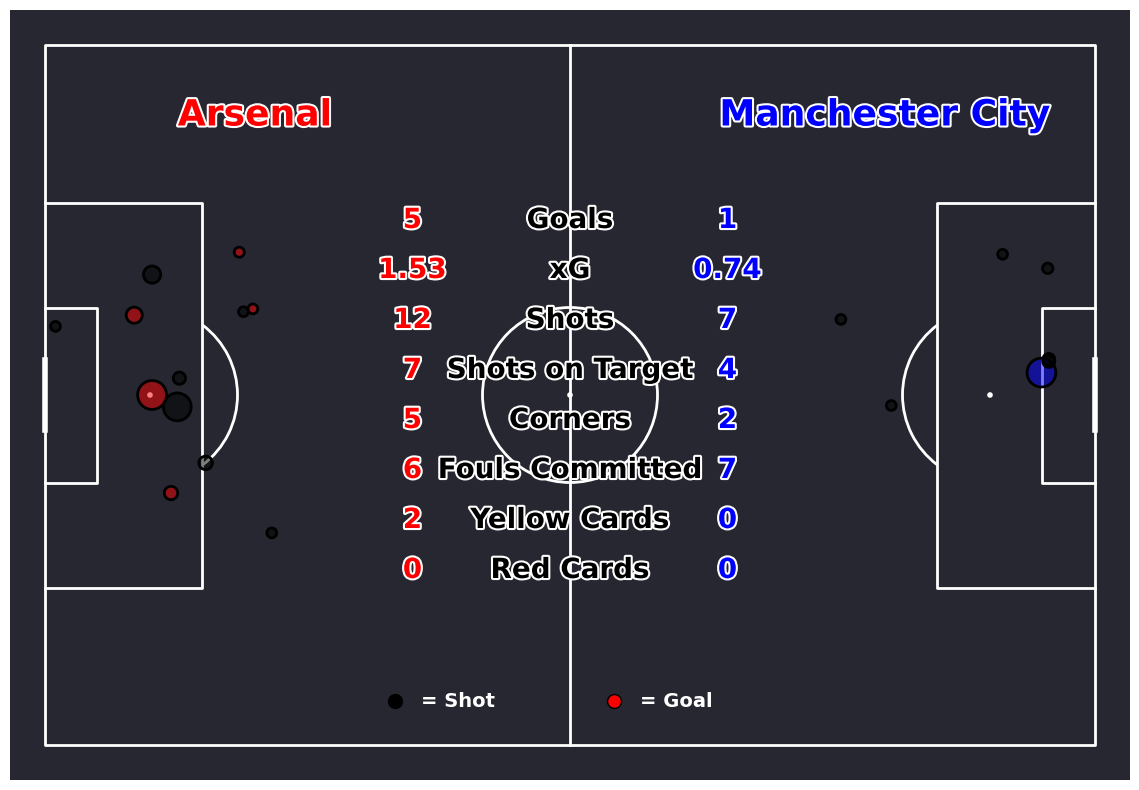

In [264]:
plot_match_shots(shots_normalised_df,match_statistics,h_team='Arsenal', a_team='Manchester City')

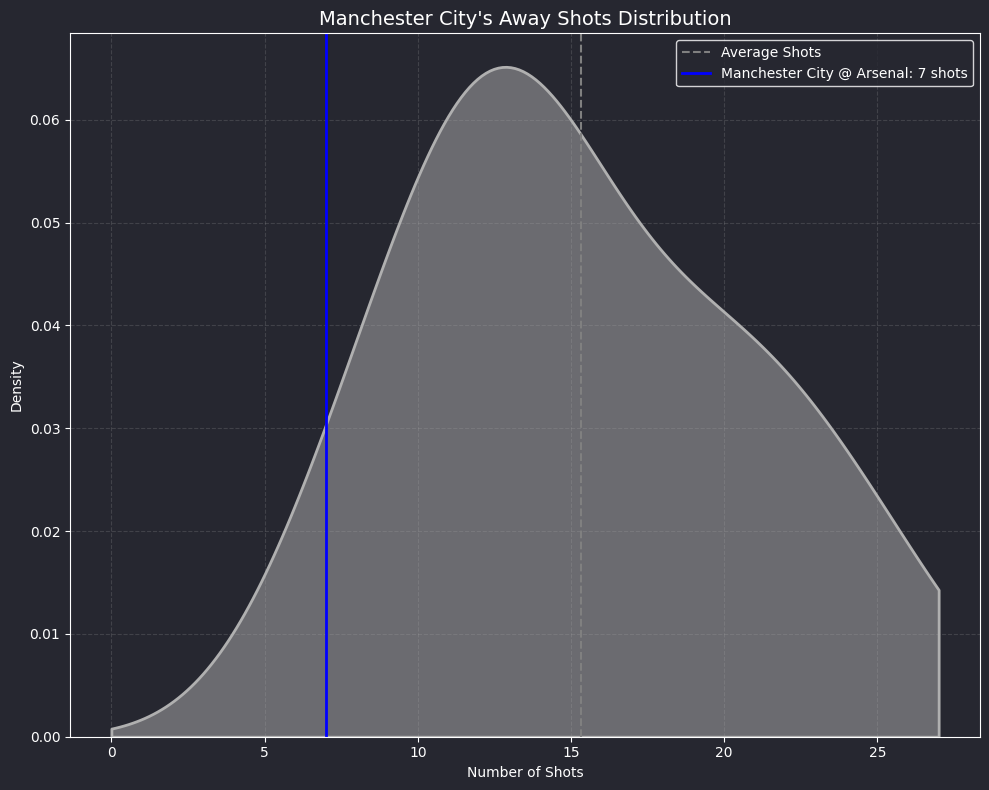

In [265]:
plot_away_shots_density(shots_normalised_df, h_team='Arsenal', a_team='Manchester City')

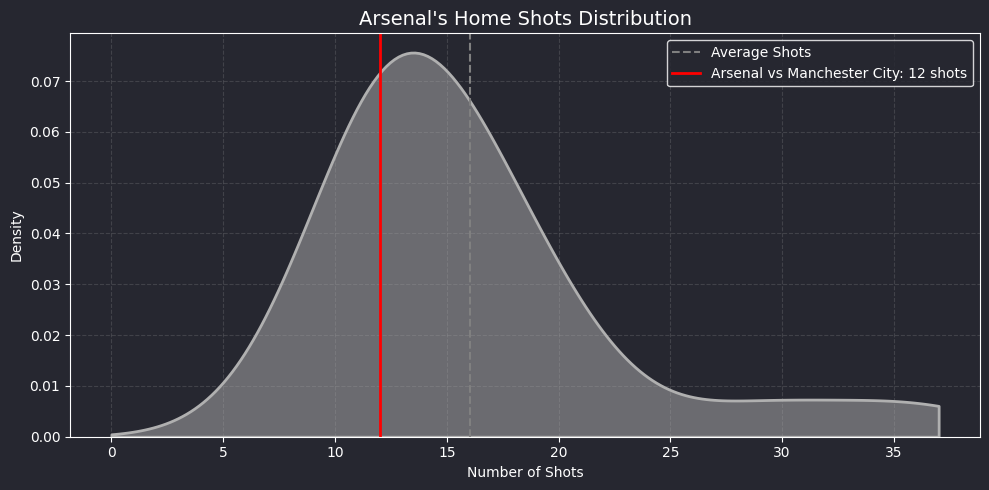

In [268]:
plot_home_shots_density(shots_normalised_df,h_team='Arsenal',a_team='Manchester City')